Khai báo thư

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Load data

  target                                               text
0   spam  Congratulations! You've been selected for a lu...
1   spam  URGENT: Your account has been compromised. Cli...
2   spam  You've won a free iPhone! Claim your prize by ...
3   spam  Act now and receive a 50% discount on all purc...
4   spam  Important notice: Your subscription will expir...
target
ham     8555
spam    2406
Name: count, dtype: int64


/tmp/ipython-input-2953363558.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette='pastel')


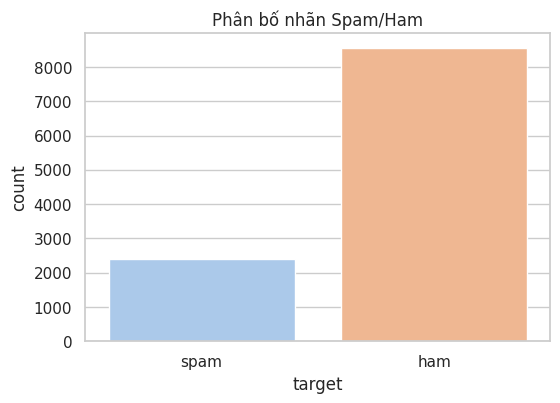

In [7]:
data = pd.read_csv('combined_dataset.csv')  # đổi theo dataset của bạn

print(data.head())
print(data['target'].value_counts())

# Trực quan hóa phân bố nhãn
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=data, palette='pastel')
plt.title("Phân bố nhãn Spam/Ham")
plt.show()


In [11]:
import pandas as pd
# Đếm số lượng từng nhãn
label_counts = data['target'].value_counts()
print(label_counts)



target
ham     8555
spam    2406
Name: count, dtype: int64


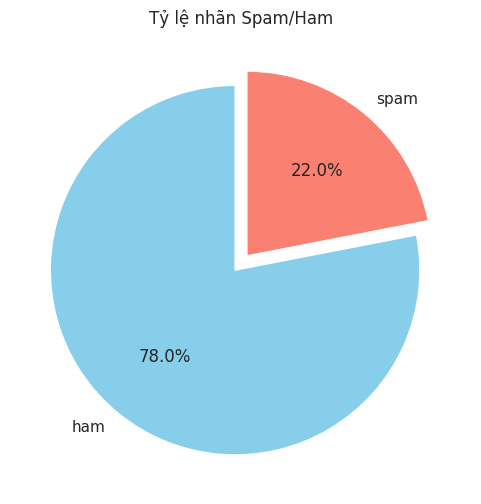

In [12]:
import matplotlib.pyplot as plt

# Đếm số lượng từng nhãn
label_counts = data['target'].value_counts()

# Trực quan hóa bằng biểu đồ tròn
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
        colors=['skyblue','salmon'], startangle=90, explode=(0.05,0.05))
plt.title("Tỷ lệ nhãn Spam/Ham")
plt.show()


In [14]:
print(data.info())

# Thống kê cơ bản
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   target           10961 non-null  object
 1   text             10961 non-null  object
 2   clean_text       10961 non-null  object
 3   length_original  10961 non-null  int64 
 4   length_clean     10961 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 428.3+ KB
None
       length_original  length_clean
count     10961.000000  10961.000000
mean        530.314935    302.766171
std        1139.178714    698.364712
min           1.000000      0.000000
25%          55.000000     33.000000
50%         139.000000     77.000000
75%         491.000000    267.000000
max       31851.000000  19913.000000


Kiểm tra missing value

In [15]:
# Số giá trị missing mỗi cột
print(data.isnull().sum())
# Nếu muốn, loại bỏ các dòng có missing
data = data.dropna(subset=['text','target'])


target             0
text               0
clean_text         0
length_original    0
length_clean       0
dtype: int64


count    10961.000000
mean       530.314935
std       1139.178714
min          1.000000
25%         55.000000
50%        139.000000
75%        491.000000
max      31851.000000
Name: length, dtype: float64


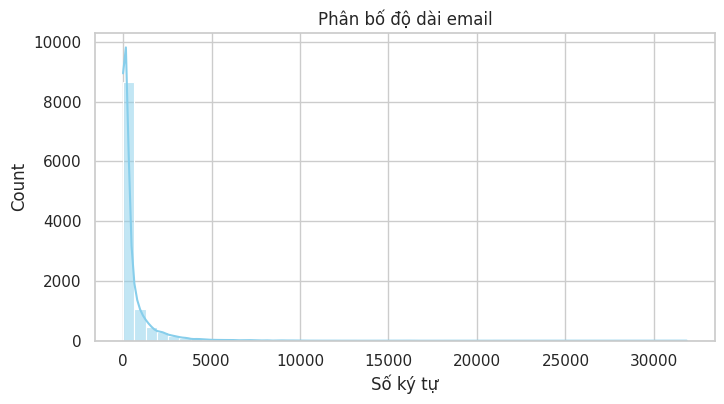

In [16]:
# Thêm cột độ dài email
data['length'] = data['text'].apply(len)

# Thống kê độ dài
print(data['length'].describe())

# Trực quan hóa
plt.figure(figsize=(8,4))
sns.histplot(data['length'], bins=50, color='skyblue', kde=True)
plt.title("Phân bố độ dài email")
plt.xlabel("Số ký tự")
plt.show()


Tiền xử lý dữ

In [17]:
def preprocess_text(text):
    # 1. Chuyển chữ thường
    text = text.lower()

    # 2. Loại email và URL
    text = re.sub(r'\S+@\S+', '', text)  # email
    text = re.sub(r'http\S+|www\S+', '', text)  # URL

    # 3. Loại ký tự không phải chữ
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Tokenization
    tokens = text.split()

    # 5. Loại stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 6. Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # 7. Nối lại thành chuỗi
    return ' '.join(tokens)


In [18]:
data['clean_text'] = data['text'].apply(preprocess_text)


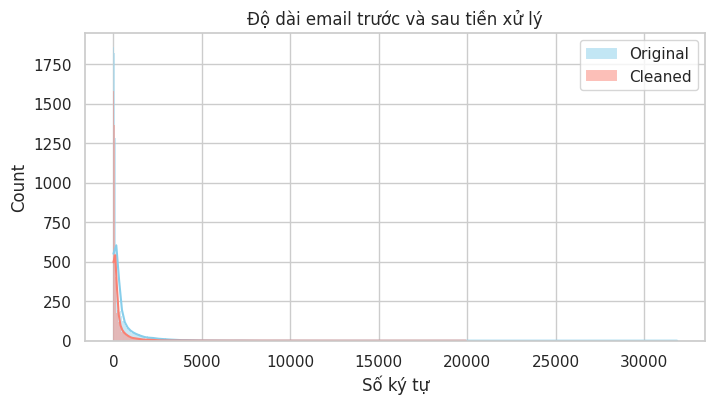

In [19]:
data['length_original'] = data['text'].apply(len)
data['length_clean'] = data['clean_text'].apply(len)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(8,4))
sns.histplot(data['length_original'], color='skyblue', label='Original', kde=True)
sns.histplot(data['length_clean'], color='salmon', label='Cleaned', kde=True)
plt.title("Độ dài email trước và sau tiền xử lý")
plt.xlabel("Số ký tự")
plt.legend()
plt.show()


Sau tiền xử lý

In [20]:
print(data[['text','clean_text']].head(5))


                                                text  \
0  Congratulations! You've been selected for a lu...   
1  URGENT: Your account has been compromised. Cli...   
2  You've won a free iPhone! Claim your prize by ...   
3  Act now and receive a 50% discount on all purc...   
4  Important notice: Your subscription will expir...   

                                          clean_text  
0  congratul youv select luxuri vacat getaway cla...  
1  urgent account compromis click reset password ...  
2             youv free iphon claim prize click link  
3       act receiv discount purchas limit time offer  
4  import notic subscript expir soon renew avoid ...  


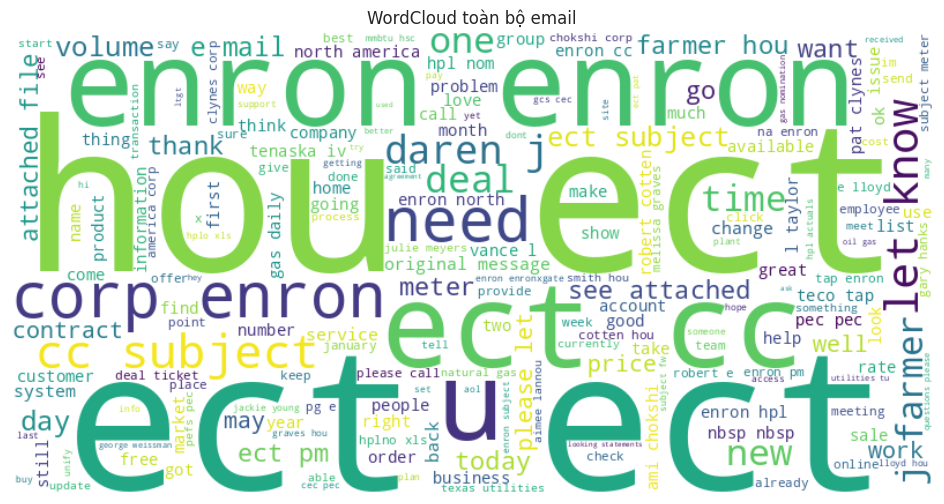

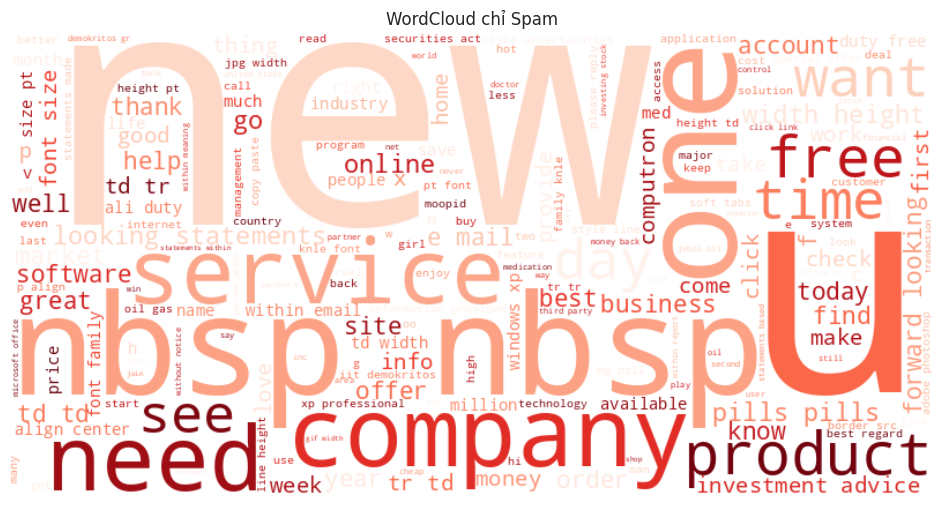

In [24]:
from wordcloud import WordCloud

def preprocess_wc(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# WordCloud toàn bộ dataset
all_text = ' '.join(data['text'].apply(preprocess_wc))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud toàn bộ email")
plt.show()

# WordCloud spam
spam_text = ' '.join(data[data['target']=='spam']['text'].apply(preprocess_wc))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud chỉ Spam")
plt.show()

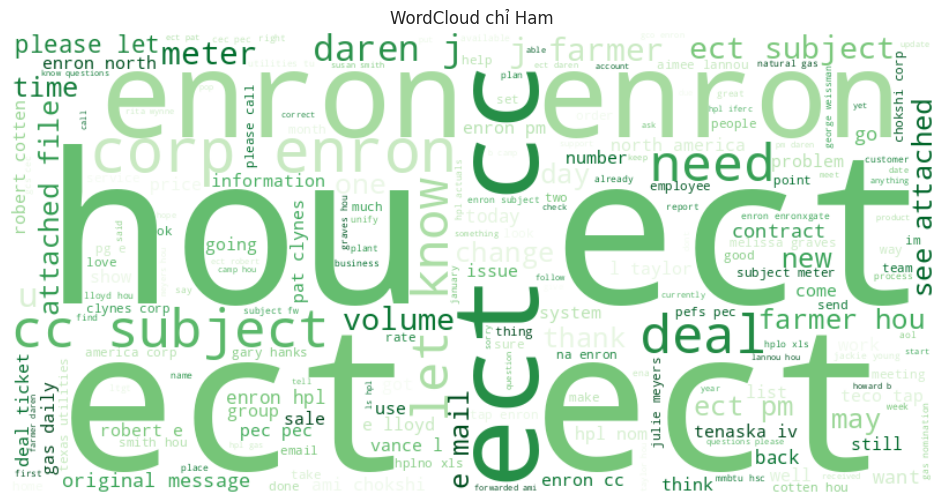

In [29]:
# WordCloud Ham
spam_text = ' '.join(data[data['target']=='ham']['text'].apply(preprocess_wc))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(spam_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud chỉ Ham")
plt.show()

In [33]:
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Tiền xử lý text
def preprocess_words(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)       # loại email
    text = re.sub(r'http\S+|www\S+', '', text) # loại URL
    text = re.sub(r'[^a-z\s]', '', text)       # loại ký tự đặc biệt
    tokens = [word for word in text.split() if word not in stop_words]
    return tokens

# Hàm lấy top từ phổ biến từ 1 Series
def get_top_words(text_series, n=20):
    all_tokens = []
    for text in text_series:
        all_tokens.extend(preprocess_words(text))
    return Counter(all_tokens).most_common(n)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# Top toàn bộ dataset
top_all = get_top_words(data['text'], n=20)
print("Top 20 từ toàn bộ dataset:", top_all)

# Top riêng nhãn Ham
top_ham = get_top_words(data[data['target']=='ham']['text'], n=20)
print("Top 20 từ Ham:", top_ham)

# Top riêng nhãn Spam
top_spam = get_top_words(data[data['target']=='spam']['text'], n=20)
print("Top 20 từ Spam:", top_spam)


Top 20 từ toàn bộ dataset: [('ect', 13900), ('hou', 7289), ('enron', 6555), ('com', 3710), ('please', 3370), ('gas', 3048), ('subject', 2897), ('deal', 2846), ('meter', 2459), ('pm', 2382), ('cc', 2377), ('hpl', 2318), ('e', 2054), ('thanks', 1984), ('daren', 1901), ('know', 1859), ('corp', 1776), ('get', 1712), ('need', 1660), ('new', 1614)]
Top 20 từ Ham: [('ect', 13897), ('hou', 7281), ('enron', 6555), ('gas', 2875), ('please', 2831), ('deal', 2797), ('subject', 2738), ('com', 2718), ('meter', 2459), ('cc', 2359), ('pm', 2352), ('hpl', 2318), ('daren', 1901), ('thanks', 1884), ('corp', 1710), ('know', 1682), ('need', 1421), ('e', 1416), ('mmbtu', 1349), ('j', 1306)]
Top 20 từ Spam: [('com', 992), ('http', 983), ('company', 731), ('e', 638), ('get', 609), ('www', 587), ('free', 559), ('please', 539), ('information', 530), ('new', 518), ('font', 515), ('td', 504), ('price', 491), ('us', 488), ('email', 480), ('statements', 476), ('p', 457), ('u', 438), ('call', 432), ('may', 429)]


In [36]:
def plot_top_words(top_words, title="Top Words"):
    words, counts = zip(*top_words)  # tách từ và số lượng
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Số lần xuất hiện")
    plt.ylabel("Từ")
    plt.show()

/tmp/ipython-input-806629525.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


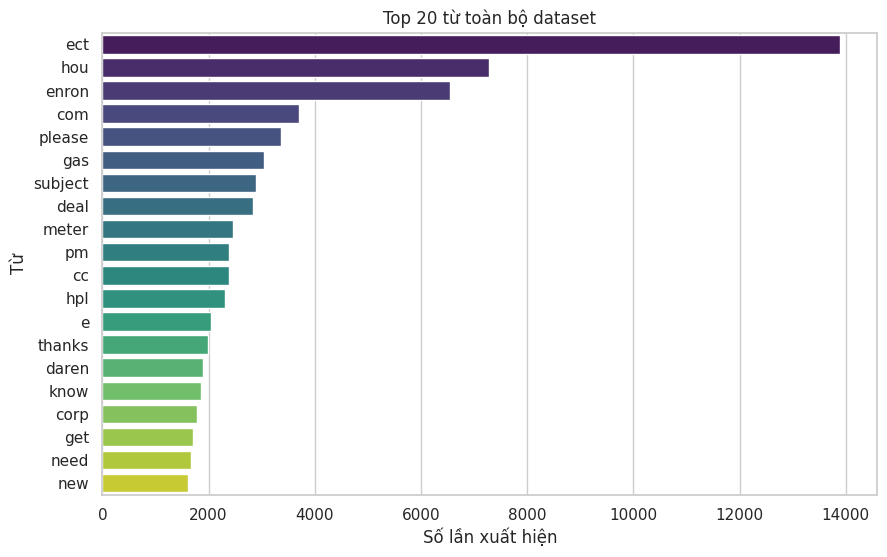

/tmp/ipython-input-806629525.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


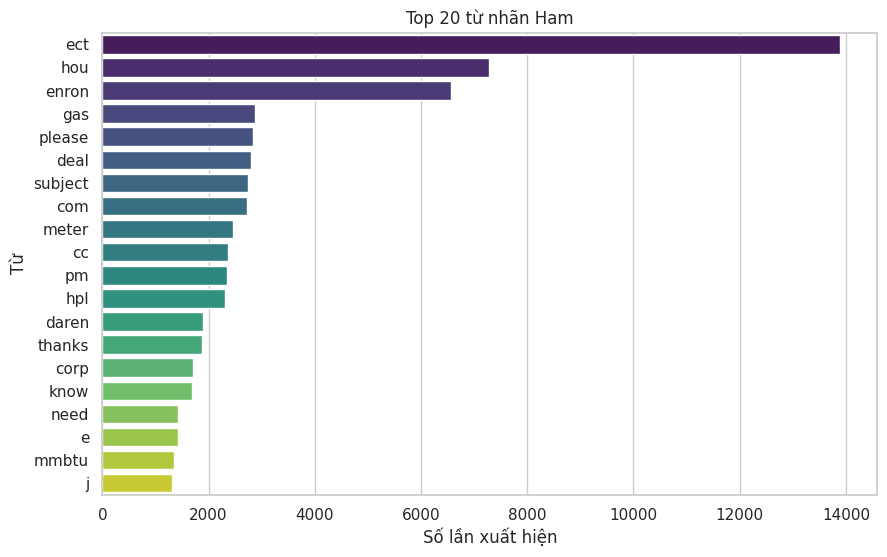

/tmp/ipython-input-806629525.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


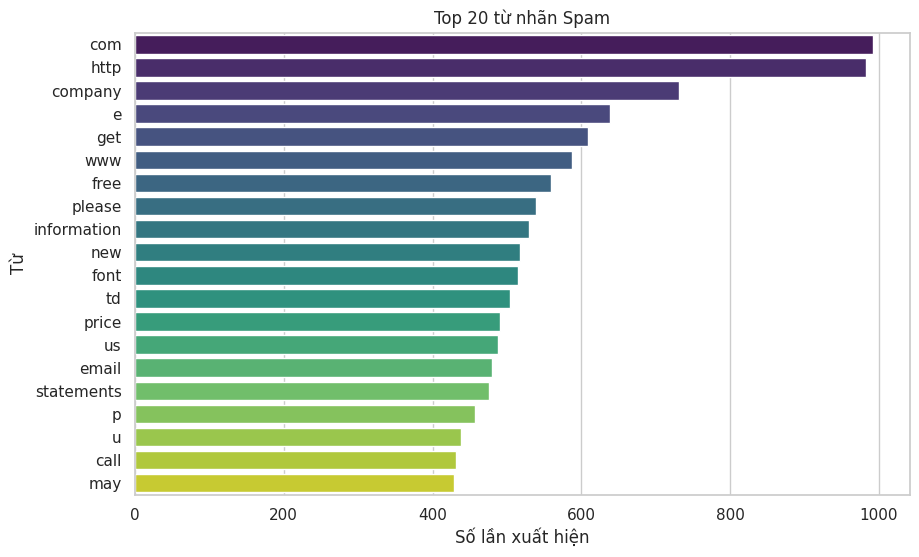

In [37]:

top_all = get_top_words(data['text'], n=20)
plot_top_words(top_all, title="Top 20 từ toàn bộ dataset")

top_ham = get_top_words(data[data['target']=='ham']['text'], n=20)
plot_top_words(top_ham, title="Top 20 từ nhãn Ham")

top_spam = get_top_words(data[data['target']=='spam']['text'], n=20)
plot_top_words(top_spam, title="Top 20 từ nhãn Spam")


chia dữ liệu

In [38]:
X = data['text']
y = data['target']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
# Kiểm tra kích thước
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (7672,)
Validation: (1644,)
Test: (1645,)


In [39]:
print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("Validation label distribution:\n", y_val.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))


Train label distribution:
 target
ham     0.780501
spam    0.219499
Name: proportion, dtype: float64
Validation label distribution:
 target
ham     0.780414
spam    0.219586
Name: proportion, dtype: float64
Test label distribution:
 target
ham     0.780547
spam    0.219453
Name: proportion, dtype: float64


fit vectorizer trên train

In [40]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    lowercase=True,
    stop_words='english'
)

X_train_vec = vectorizer.fit_transform(X_train)  # fit trên train
X_val_vec = vectorizer.transform(X_val)          # transform trên val
X_test_vec = vectorizer.transform(X_test)        # transform trên test

In [41]:
print("TF-IDF shapes:", X_train_vec.shape, X_val_vec.shape, X_test_vec.shape)

TF-IDF shapes: (7672, 5000) (1644, 5000) (1645, 5000)


In [47]:
from sklearn.preprocessing import StandardScaler

# Chuyển sang dense array
X_train_dense = X_train_vec.toarray()
X_val_dense = X_val_vec.toarray()
X_test_dense = X_test_vec.toarray()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_val_scaled = scaler.transform(X_val_dense)
X_test_scaled = scaler.transform(X_test_dense)


Train 3 mô hình NB / Logistic Regression / LinearSVM

In [49]:
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)

# --- Logistic Regression (solver 'saga' hỗ trợ sparse) ---
model_lr = LogisticRegression(max_iter=1000, solver='saga')
model_lr.fit(X_train_vec, y_train)

# --- Linear SVM (dual=False hỗ trợ sparse tốt) ---
model_svm = LinearSVC(dual=False)
model_svm.fit(X_train_vec, y_train)

LinearSVC(dual=False)

In [50]:
sample_texts = X_val[:5]

print("Sample predictions:")
print("Naive Bayes :", model_nb.predict(X_val_vec[:5]))
print("Logistic Reg:", model_lr.predict(X_val_vec[:5]))
print("Linear SVM  :", model_svm.predict(X_val_vec[:5]))


Sample predictions:
Naive Bayes : ['ham' 'ham' 'ham' 'ham' 'ham']
Logistic Reg: ['ham' 'ham' 'ham' 'ham' 'ham']
Linear SVM  : ['ham' 'ham' 'ham' 'ham' 'ham']


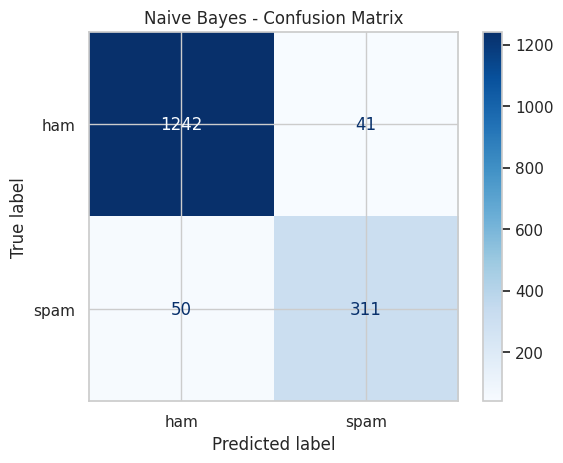

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_nb = model_nb.predict(X_val_vec)
cm = confusion_matrix(y_val, y_pred_nb, labels=model_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_nb.classes_)
disp.plot(cmap='Blues')
plt.title("Naive Bayes - Confusion Matrix")
plt.show()


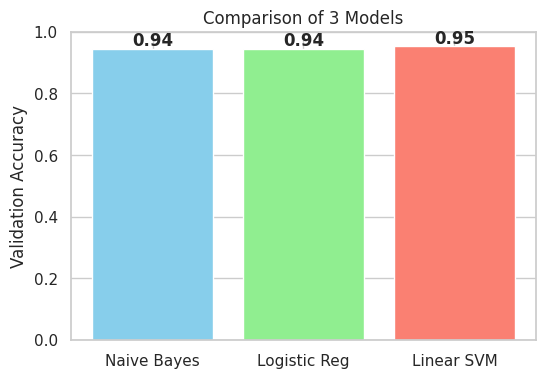

In [52]:
import matplotlib.pyplot as plt

# Tính accuracy
acc_dict = {
    "Naive Bayes": accuracy_score(y_val, model_nb.predict(X_val_vec)),
    "Logistic Reg": accuracy_score(y_val, model_lr.predict(X_val_vec)),
    "Linear SVM": accuracy_score(y_val, model_svm.predict(X_val_vec))
}

# Vẽ bar chart
plt.figure(figsize=(6,4))
plt.bar(acc_dict.keys(), acc_dict.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0,1)
plt.ylabel("Validation Accuracy")
plt.title("Comparison of 3 Models")
for i, v in enumerate(acc_dict.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


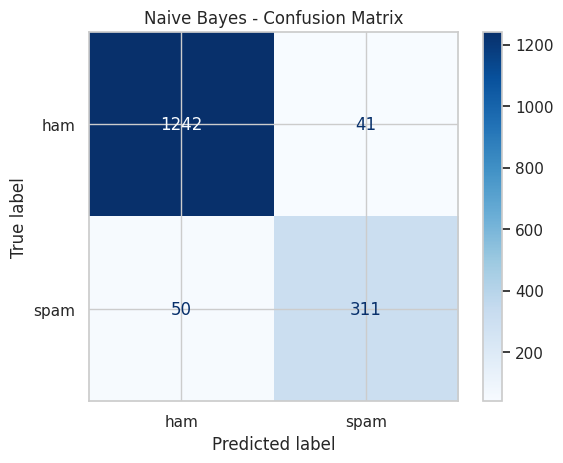

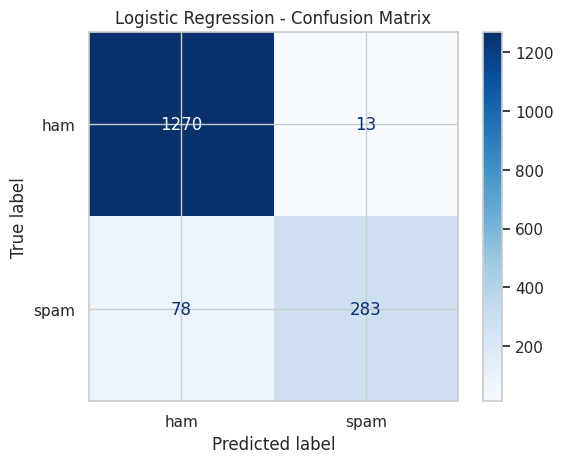

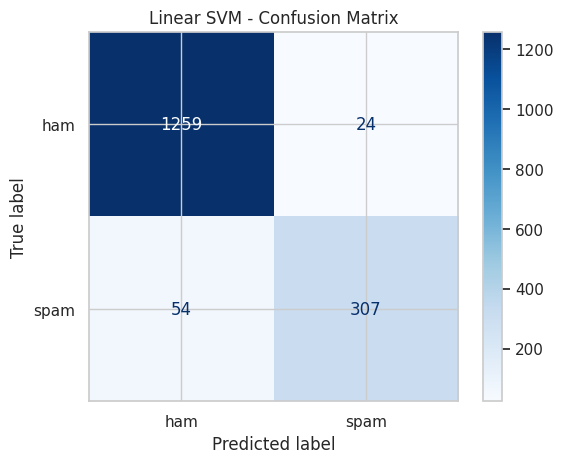

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = {"Naive Bayes": model_nb, "Logistic Regression": model_lr, "Linear SVM": model_svm}

for name, model in models.items():
    y_pred = model.predict(X_val_vec)
    cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [54]:
import numpy as np

def show_top_words(model, vectorizer, n=10):
    if hasattr(model, 'coef_'):  # LoR/SVM
        coefs = model.coef_[0]
        top_idx = np.argsort(coefs)[-n:]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_idx]
        print(f"Top {n} words for {type(model).__name__}: {top_words}")
    elif hasattr(model, 'feature_log_prob_'):  # NB
        top_idx = np.argsort(model.feature_log_prob_[1])[-n:]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_idx]
        print(f"Top {n} words for {type(model).__name__}: {top_words}")

for model in [model_nb, model_lr, model_svm]:
    show_top_words(model, vectorizer)


Top 10 words for MultinomialNB: ['claim', 'stop', 'click', 'txt', 'mobile', 'new', 'www', 'com', 'http', 'free']
Top 10 words for LogisticRegression: ['paliourg', 'prize', '50', 'free', '150p', 'txt', 'click', 'claim', 'mobile', 'http']
Top 10 words for LinearSVC: ['women', 'uk', 'loading', 'dating', '2004', 'paliourg', '50', 'remove', '150p', 'http']


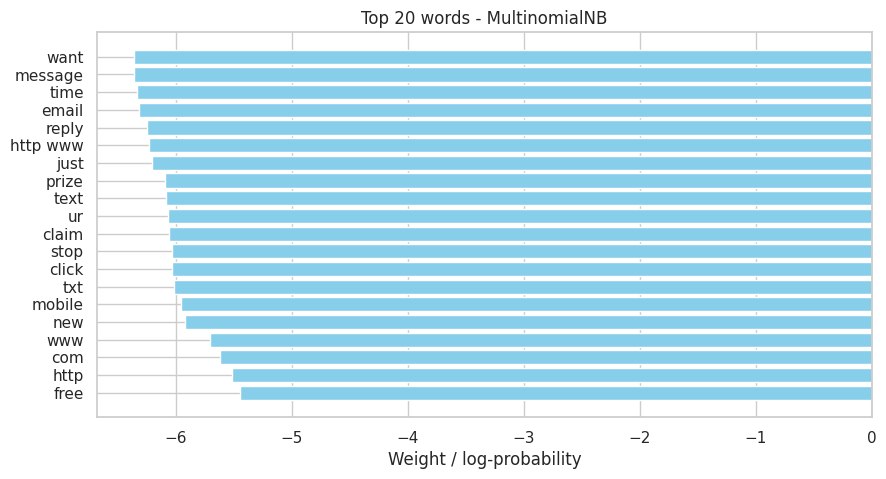

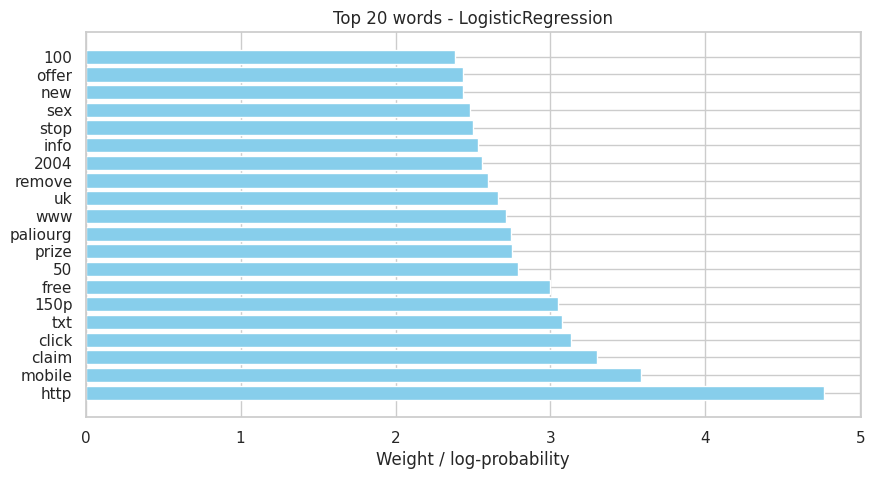

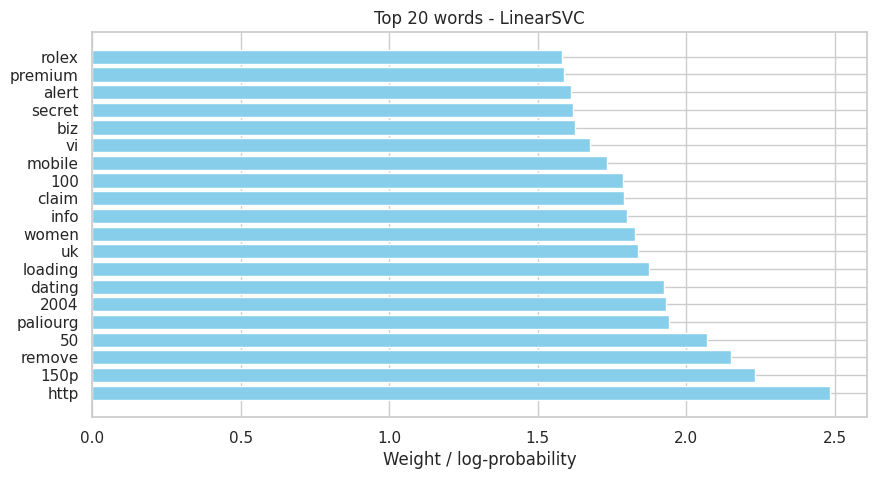

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(model, vectorizer, n=20):
    feature_names = vectorizer.get_feature_names_out()

    if hasattr(model, 'coef_'):  # LoR / SVM
        coefs = model.coef_[0]
        top_idx = np.argsort(coefs)[-n:]
        top_words = feature_names[top_idx]
        top_values = coefs[top_idx]
    elif hasattr(model, 'feature_log_prob_'):  # NB
        # spam label index = 1
        top_idx = np.argsort(model.feature_log_prob_[1])[-n:]
        top_words = feature_names[top_idx]
        top_values = model.feature_log_prob_[1][top_idx]

    plt.figure(figsize=(10,5))
    plt.barh(top_words, top_values, color='skyblue')
    plt.xlabel("Weight / log-probability")
    plt.title(f"Top {n} words - {type(model).__name__}")
    plt.gca().invert_yaxis()
    plt.show()

# Vẽ cho cả 3 mô hình
for model in [model_nb, model_lr, model_svm]:
    plot_top_words(model, vectorizer, n=20)


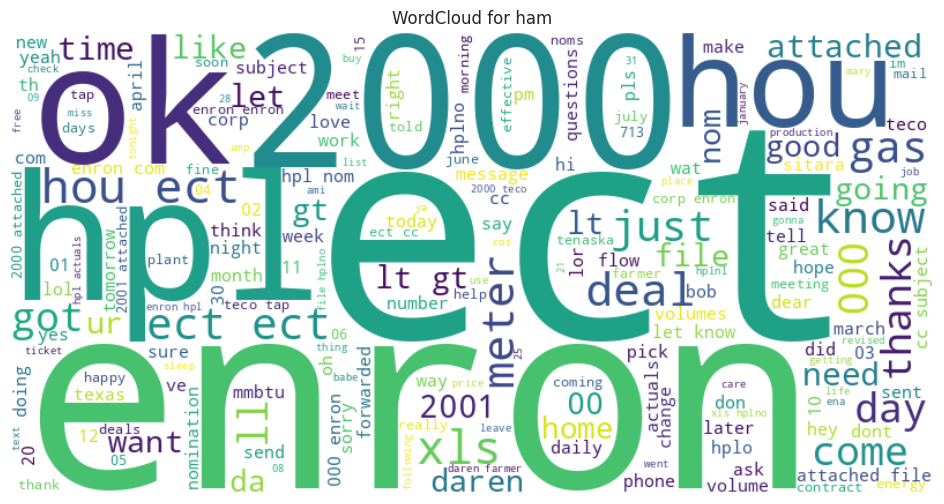

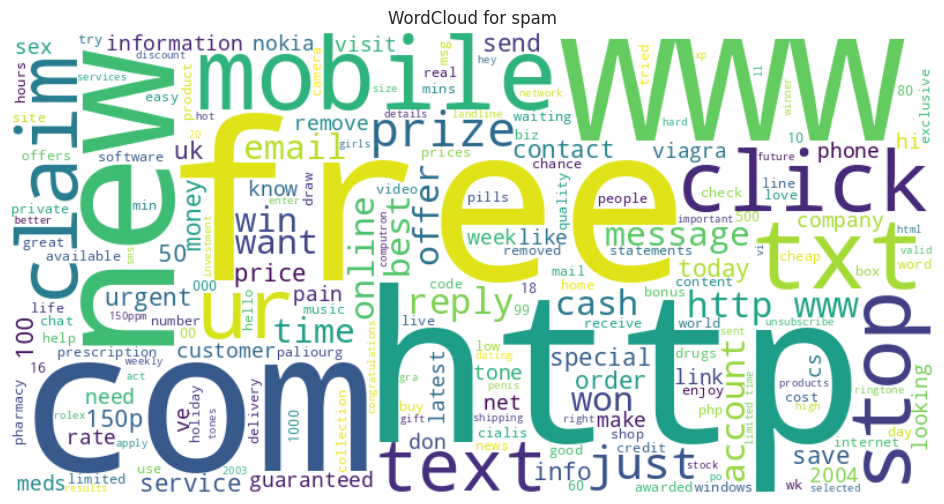

In [59]:
from wordcloud import WordCloud

def wordcloud_from_tfidf(X_vec, y_labels, target_label, vectorizer):
    # Chỉ lấy các mẫu của nhãn target_label
    idx = np.where(y_labels == target_label)[0]
    tfidf_sum = X_vec[idx].sum(axis=0)  # tổng TF-IDF
    tfidf_sum = np.asarray(tfidf_sum).flatten()
    features = vectorizer.get_feature_names_out()

    freq_dict = {features[i]: tfidf_sum[i] for i in range(len(features))}
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {target_label}")
    plt.show()

# WordCloud Ham
wordcloud_from_tfidf(X_train_vec, y_train, target_label="ham", vectorizer=vectorizer)
# WordCloud Spam
wordcloud_from_tfidf(X_train_vec, y_train, target_label="spam", vectorizer=vectorizer)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Các mô hình
models = {"Naive Bayes": model_nb, "Logistic Regression": model_lr, "Linear SVM": model_svm}

# Các tập
datasets = {"Train": X_train_vec, "Validation": X_val_vec, "Test": X_test_vec}
y_sets = {"Train": y_train, "Validation": y_val, "Test": y_test}

# Khởi tạo DataFrame
rows = []

for model_name, model in models.items():
    for set_name, X_set in datasets.items():
        y_true = y_sets[set_name]
        y_pred = model.predict(X_set)
        rows.append({
            "Model": model_name,
            "Dataset": set_name,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, pos_label="spam"),
            "Recall": recall_score(y_true, y_pred, pos_label="spam"),
            "F1-score": f1_score(y_true, y_pred, pos_label="spam")
        })

df_metrics = pd.DataFrame(rows)
print(df_metrics)

                 Model     Dataset  Accuracy  Precision    Recall  F1-score
0          Naive Bayes       Train  0.959854   0.922604  0.891924  0.907005
1          Naive Bayes  Validation  0.944647   0.883523  0.861496  0.872370
2          Naive Bayes        Test  0.951368   0.900285  0.875346  0.887640
3  Logistic Regression       Train  0.957377   0.971508  0.830166  0.895293
4  Logistic Regression  Validation  0.944647   0.956081  0.783934  0.861492
5  Logistic Regression        Test  0.941033   0.955172  0.767313  0.850998
6           Linear SVM       Train  0.989964   0.989640  0.964371  0.976842
7           Linear SVM  Validation  0.952555   0.927492  0.850416  0.887283
8           Linear SVM        Test  0.956839   0.944785  0.853186  0.896652


In [64]:
df_pivot = df_metrics.pivot(index="Model", columns="Dataset", values="Accuracy")
print(df_pivot)


Dataset                  Test     Train  Validation
Model                                              
Linear SVM           0.956839  0.989964    0.952555
Logistic Regression  0.941033  0.957377    0.944647
Naive Bayes          0.951368  0.959854    0.944647


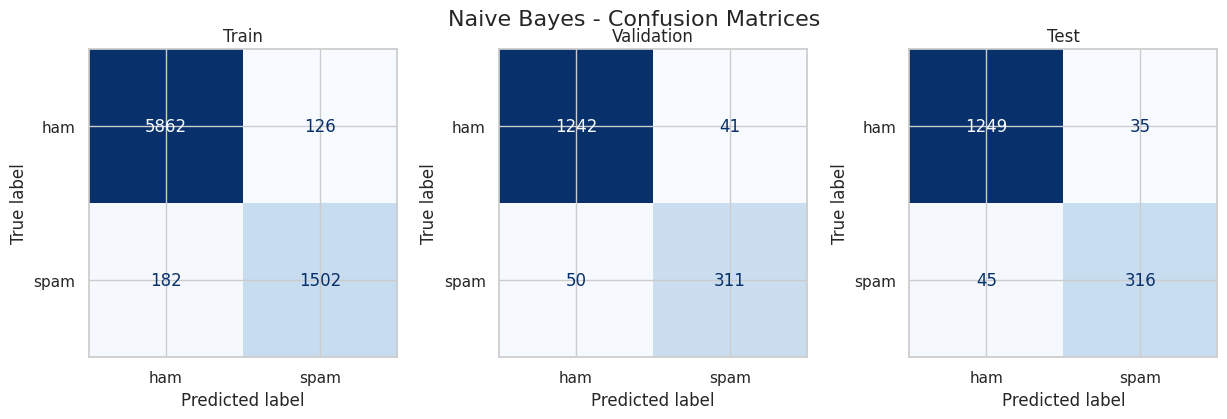

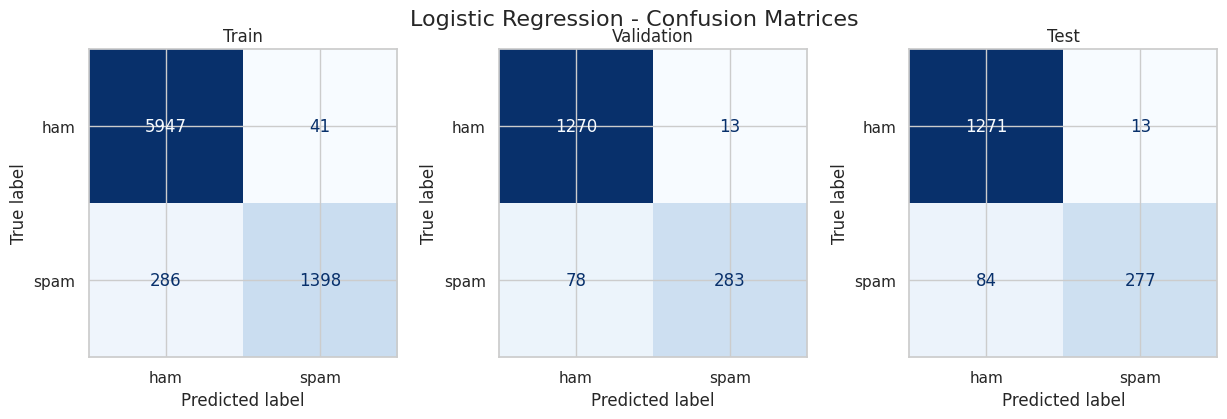

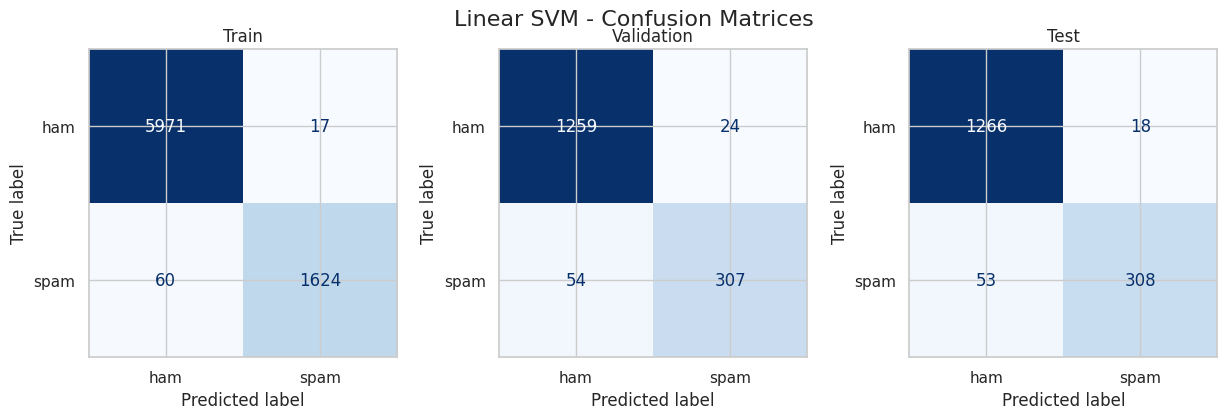

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {"Naive Bayes": model_nb, "Logistic Regression": model_lr, "Linear SVM": model_svm}
datasets = {"Train": (X_train_vec, y_train),
            "Validation": (X_val_vec, y_val),
            "Test": (X_test_vec, y_test)}

for model_name, model in models.items():
    plt.figure(figsize=(15,4))
    for i, (dataset_name, (X_set, y_set)) in enumerate(datasets.items()):
        y_pred = model.predict(X_set)
        cm = confusion_matrix(y_set, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        plt.subplot(1,3,i+1)
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{dataset_name}")
    plt.suptitle(f"{model_name} - Confusion Matrices", fontsize=16)
    plt.show()


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
models = {"Naive Bayes": model_nb,
          "Logistic Regression": model_lr,
          "Linear SVM": model_svm}
datasets = {"Train": (X_train_vec, y_train),
            "Validation": (X_val_vec, y_val),
            "Test": (X_test_vec, y_test)}
rows = []

for model_name, model in models.items():
    for set_name, (X_set, y_set) in datasets.items():
        y_pred = model.predict(X_set)
        rows.append({
            "Model": model_name,
            "Dataset": set_name,
            "Accuracy": accuracy_score(y_set, y_pred),
            "Precision": precision_score(y_set, y_pred, pos_label="spam"),
            "Recall": recall_score(y_set, y_pred, pos_label="spam"),
            "F1-score": f1_score(y_set, y_pred, pos_label="spam")
        })
df_metrics = pd.DataFrame(rows)
df_pivot_acc = df_metrics.pivot(index="Model", columns="Dataset", values="Accuracy")
df_pivot_precision = df_metrics.pivot(index="Model", columns="Dataset", values="Precision")
df_pivot_recall = df_metrics.pivot(index="Model", columns="Dataset", values="Recall")
df_pivot_f1 = df_metrics.pivot(index="Model", columns="Dataset", values="F1-score")
print("=== Accuracy ===")
print(df_pivot_acc.round(4))
print("\n=== Precision ===")
print(df_pivot_precision.round(4))
print("\n=== Recall ===")
print(df_pivot_recall.round(4))
print("\n=== F1-score ===")
print(df_pivot_f1.round(4))

=== Accuracy ===
Dataset                Test   Train  Validation
Model                                          
Linear SVM           0.9568  0.9900      0.9526
Logistic Regression  0.9410  0.9574      0.9446
Naive Bayes          0.9514  0.9599      0.9446

=== Precision ===
Dataset                Test   Train  Validation
Model                                          
Linear SVM           0.9448  0.9896      0.9275
Logistic Regression  0.9552  0.9715      0.9561
Naive Bayes          0.9003  0.9226      0.8835

=== Recall ===
Dataset                Test   Train  Validation
Model                                          
Linear SVM           0.8532  0.9644      0.8504
Logistic Regression  0.7673  0.8302      0.7839
Naive Bayes          0.8753  0.8919      0.8615

=== F1-score ===
Dataset                Test   Train  Validation
Model                                          
Linear SVM           0.8967  0.9768      0.8873
Logistic Regression  0.8510  0.8953      0.8615
Naive Bayes       